### Setup

In [20]:
import os, sys
# HOME = os.environ['HOME']  # change if necessary
HOME = '/workspace/wilson'
sys.path.append(f'{HOME}/Finite-groups/src')

In [21]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from llc import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# t.set_grad_enabled(False)
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [23]:
MODEL_DIR = '2024-12-20_19-12-16_S4_A4x2_MLP2_32_ubias_wd2e-5_BIG'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir, sel='final')
# models, params = load_models(local_dir, sel=0)
models = models[0]

# IMPORTANT: set seed before creating data (which samples train_data)
t.manual_seed(params.seed)
np.random.seed(params.seed)
random.seed(params.seed)

data = GroupData(params)
train_x = t.tensor(data.train_data)[:,:2]
train_z = t.tensor(data.train_data)[:,2]

/workspace/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


Intersection size: 336/576 (0.58)
Added 336 elements from intersection
Added 0 elements from group 0: S(4)
Added 0 elements from group 1: times(A(4), Z(2))
Train set size: 336/576 (0.58)


In [8]:
ACC_THRESH = 0.999
loss_dict = test_loss(models.to(device), data)
g0_grokked = (loss_dict['G0_acc'] > ACC_THRESH)
g1_grokked = (loss_dict['G1_acc'] > ACC_THRESH)
grokked = g0_grokked | g1_grokked
print('G0 grokked', g0_grokked.sum())
print('G1 grokked', g1_grokked.sum())

G0 grokked tensor(603, device='cuda:0')
G1 grokked tensor(43, device='cuda:0')


In [9]:
g0_models = models[g0_grokked.nonzero().flatten()]
g1_models = models[g1_grokked.nonzero().flatten()]
none_models = models[(~(g0_grokked | g1_grokked)).nonzero().flatten()]

### Train loss and weight norm

In [7]:
train_data = t.tensor(data.train_data)
x = train_data[:,:2].to(device)
z = train_data[:,2].to(device)
output = models(x)
train_loss = get_cross_entropy(output, z)
train_acc = get_accuracy(output, z)
train_loss.shape, train_acc.shape

(torch.Size([10000]), torch.Size([10000]))

In [8]:
norms = weight_norm(models)

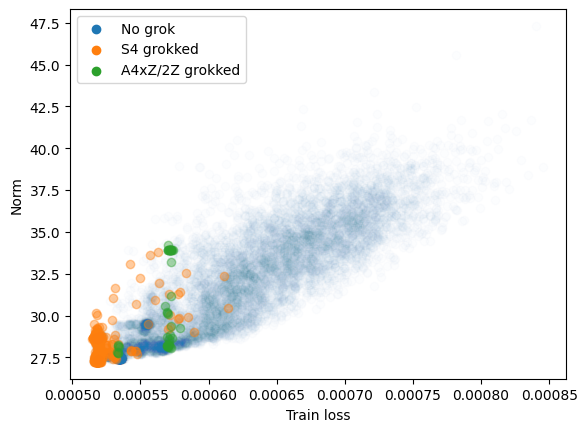

In [9]:
plt.scatter(train_loss[~grokked].detach().cpu(), norms[~grokked].detach().cpu(), alpha=0.01, label='No grok')
plt.scatter(train_loss[g0_grokked].detach().cpu(), norms[g0_grokked].detach().cpu(), label='S4 grokked', alpha=0.4)
plt.scatter(train_loss[g1_grokked].detach().cpu(), norms[g1_grokked].detach().cpu(), label='A4xZ/2Z grokked', alpha=0.4)
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.xlabel('Train loss')
plt.ylabel('Norm')
plt.show()

### LLC

In [10]:
llc_params = {
    'eps': 8e-4,
    'beta': 1e3,
    'gamma': 1.,
    'chains': 100,
    'cbatch_size': 50,
    'replacement': False,
    'behavioral': False,
    'epochs': 3000,
    # 'epochs': 10,
}

In [11]:
g0_llc, g0_trace = get_llc(g0_models, data, **llc_params)
g1_llc, g1_trace = get_llc(g1_models, data, **llc_params)
none_llc, none_trace = get_llc(none_models[:500], data, **llc_params)

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

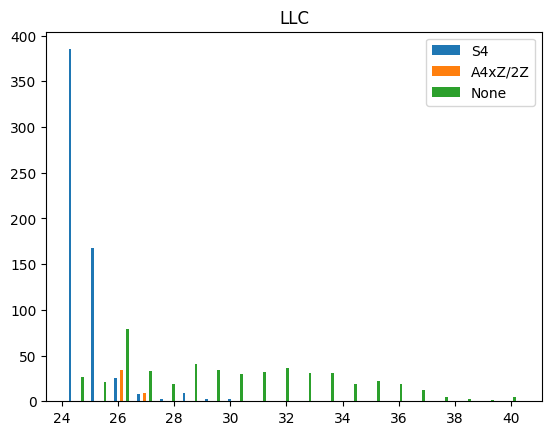

In [15]:
plt.hist([a.detach().cpu().numpy() for a in [g0_llc, g1_llc, none_llc]], bins=20, histtype='bar', label=['S4', 'A4xZ/2Z', 'None'], width=0.1)
plt.title('LLC')
plt.legend()
plt.show()

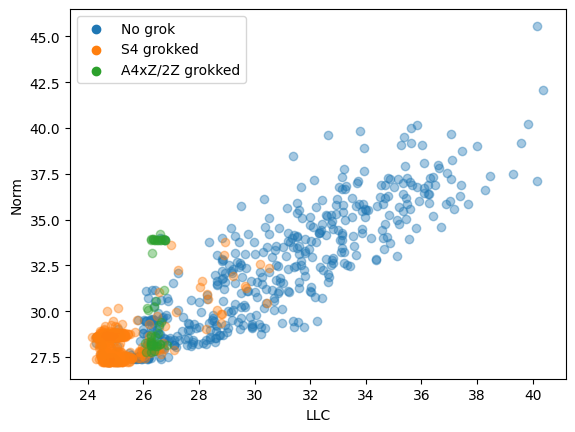

In [16]:
plt.scatter(none_llc.detach().cpu(), norms[~grokked][:500].detach().cpu(), alpha=0.4, label='No grok')
plt.scatter(g0_llc.detach().cpu(), norms[g0_grokked].detach().cpu(), label='S4 grokked', alpha=0.4)
plt.scatter(g1_llc.detach().cpu(), norms[g1_grokked].detach().cpu(), label='A4xZ/2Z grokked', alpha=0.4)
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.xlabel('LLC')
plt.ylabel('Norm')
plt.show()

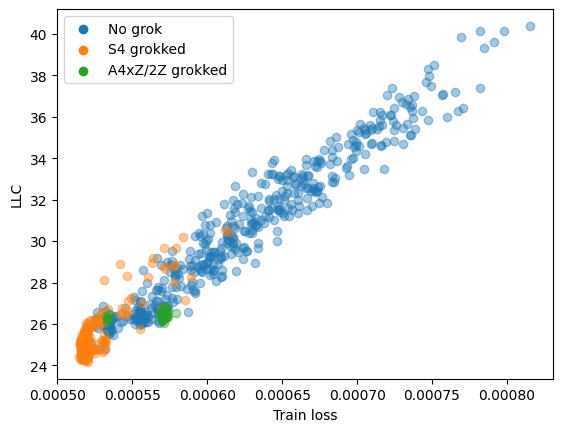

In [19]:
plt.scatter(train_loss[~grokked][:500].detach().cpu(), none_llc.detach().cpu(), alpha=0.4, label='No grok')
plt.scatter(train_loss[g0_grokked].detach().cpu(), g0_llc.detach().cpu(), label='S4 grokked', alpha=0.4)
plt.scatter(train_loss[g1_grokked].detach().cpu(), g1_llc.detach().cpu(), label='A4xZ/2Z grokked', alpha=0.4)
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.xlabel('Train loss')
plt.ylabel('LLC')
plt.show()

In [39]:
none_llc

tensor([37.7436, 30.2246, 31.3638, 24.8283, 26.9936, 26.6868, 33.0231, 29.3923,
        26.7915, 32.1474, 29.1077, 29.7145, 26.3947, 26.8998, 30.5455, 25.9352,
        30.5094, 35.8288, 24.3901, 33.7338, 24.2730, 33.5927, 34.7483, 27.6507,
        25.9691, 37.5047, 33.3037, 30.8781, 36.3799, 24.2400, 35.4319, 25.9159,
        33.1007, 34.9681, 35.1045, 31.1862, 24.8016, 26.9675, 33.4614, 25.9430,
        37.3856, 34.9138, 28.3284, 33.9492, 24.9591, 26.2995, 30.5487, 24.5400,
        25.4951, 27.3080, 26.1950, 27.8415, 35.0645, 28.5047, 26.9714, 32.3011,
        27.9944, 29.9088, 26.0048, 35.7658, 29.5153, 26.9648, 24.8905, 25.0875,
        31.5110, 28.8773, 26.2135, 31.7575, 29.8446, 26.0783, 26.0220, 37.3990,
        24.5295, 34.6216, 30.7982, 26.5391, 28.7863, 30.5868, 29.4972, 26.4468,
        31.3005, 24.6329, 37.3102, 31.6945, 32.2794, 28.0639, 30.9229, 35.0991,
        24.5763, 35.4760, 25.7322, 33.6456, 26.3293, 24.1042, 26.6148, 26.6724,
        28.4625, 25.9411, 25.8209, 32.12

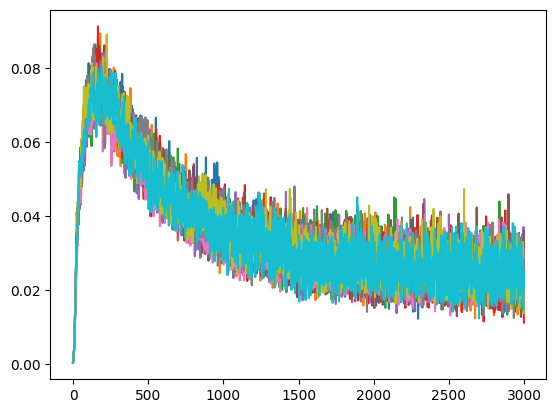

In [27]:
for i in range(10):
    plt.plot(g0_trace[i].detach().cpu())

### Spectral entropy

In [51]:
def spectral_entropy(A):
    # Preserve instance dimension
    S = t.linalg.svdvals(A)
    S /= S.sum(dim=-1, keepdim=True)
    return -(S * t.log(S)).sum(dim=-1)

In [52]:
g0_entropy = spectral_entropy(g0_models.unembedding)
g1_entropy = spectral_entropy(g1_models.unembedding)
none_entropy = spectral_entropy(none_models.unembedding)

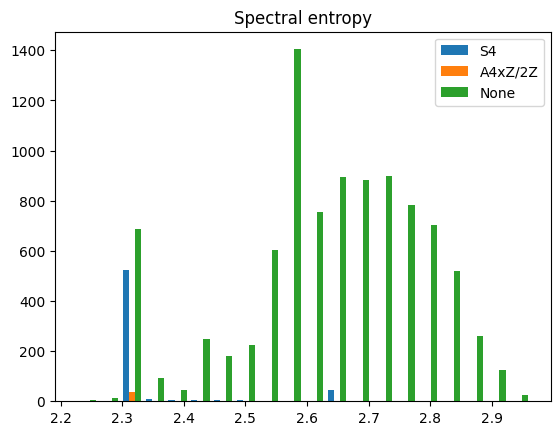

In [53]:
plt.hist([a.detach().cpu().numpy() for a in [g0_entropy, g1_entropy, none_entropy]], bins=20, histtype='bar', label=['S4', 'A4xZ/2Z', 'None'], width=0.01)
plt.title('Spectral entropy')
plt.legend()
plt.show()

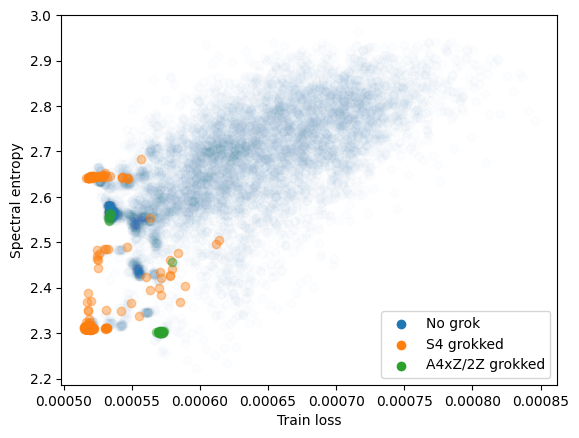

In [55]:
plt.scatter(train_loss[~grokked].detach().cpu(), none_entropy.detach().cpu(), alpha=0.01, label='No grok')
plt.scatter(train_loss[g0_grokked].detach().cpu(), g0_entropy.detach().cpu(), label='S4 grokked', alpha=0.4)
plt.scatter(train_loss[g1_grokked].detach().cpu(), g1_entropy.detach().cpu(), label='A4xZ/2Z grokked', alpha=0.4)
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.xlabel('Train loss')
plt.ylabel('Spectral entropy')
plt.show()

### Circuit efficiency

In [10]:
def scale_model(model, scale):
    model = copy.deepcopy(model)
    for name, p in model.named_parameters():
        if 'bias' in name:
            p.data *= scale**3
        else:
            p.data *= scale
    return model
    

In [14]:
g0_models = g0_models.to(device)
train_x = train_x.to(device)
train_z = train_z.to(device)

In [15]:
g0_scaled_models = scale_model(g0_models, 1.5)
logits = g0_models(train_x)
scaled_logits = g0_scaled_models(train_x)
t.abs(logits * 1.5**3 - scaled_logits).max()

tensor(3.0518e-05, device='cuda:0', grad_fn=<MaxBackward1>)

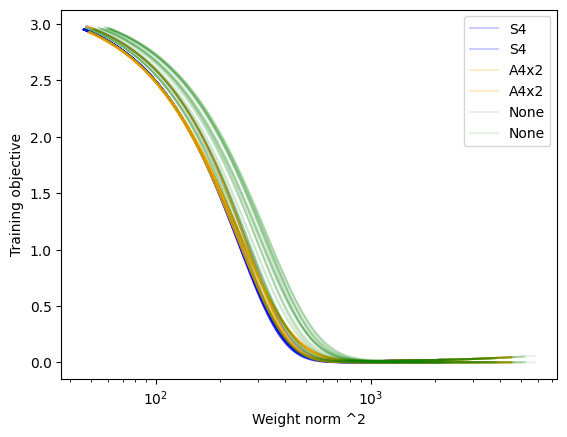

In [19]:
def plot_scales(model, scales, c='blue', alpha=0.1, label=None):
    model_scaled = MLP2.stack([scale_model(model, scale) for scale in scales])
    losses = get_cross_entropy(model_scaled(train_x), train_z).detach().cpu()
    norms = weight_norm(model_scaled).detach().cpu()
    plt.plot(norms**2, losses, alpha=alpha, c=c, label=label)
    plt.plot(norms**2, losses + params.weight_decay/2 * norms**2, alpha=alpha, c=c, label=label)

scales = 2**np.linspace(-2, 0.5, 100)
for i in range(20):
    plot_scales(g0_models[i], scales, c='blue', alpha=0.2, label='S4' if i==0 else None)
for i in range(20):
    plot_scales(g1_models[i], scales, c='orange', alpha=0.2, label='A4x2' if i==0 else None)
for i in range(20):
    plot_scales(none_models[i], scales, c='green', alpha=0.1, label='None' if i==0 else None)
plt.xscale('log')
plt.xlabel('Weight norm ^2')
# plt.ylabel('Training loss')
plt.ylabel('Training objective')
plt.legend()
plt.show()

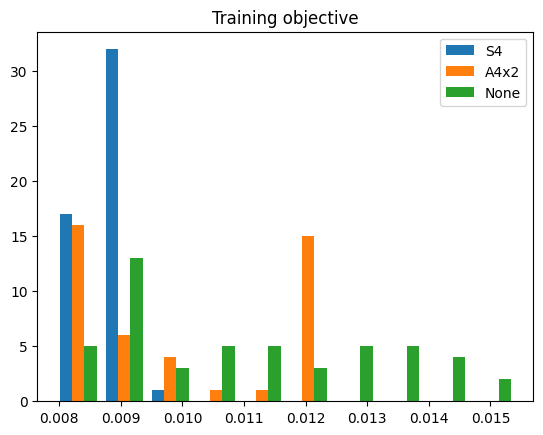

In [82]:
def get_objective(model):
    loss = get_cross_entropy(model(train_x), train_z).detach().cpu()
    norm = weight_norm(model)
    return loss + params.weight_decay / 2 * norm**2

g0_objs = get_objective(g0_models[:50])
g1_objs = get_objective(g1_models[:50])
none_objs = get_objective(none_models[:50])
plt.hist([a.detach().cpu().numpy() for a in [g0_objs, g1_objs, none_objs]], histtype='bar', label=['S4', 'A4x2', 'None'])#, width=0.01)
plt.title('Training objective')
plt.legend()
plt.show()

In [ ]:
def normalize_model(model, to_norm=1):
    norm = weight_norm(model).item()
    return scale_model(model, scale=to_norm**(/norm)

In [79]:
g0_objs, g1_objs, none_objs

(tensor([0.0087, 0.0088, 0.0087, 0.0079, 0.0081, 0.0088, 0.0087, 0.0082, 0.0087,
         0.0087, 0.0088, 0.0091, 0.0090, 0.0087, 0.0080, 0.0087, 0.0079, 0.0087,
         0.0087, 0.0087, 0.0102, 0.0083, 0.0086, 0.0087, 0.0087, 0.0087, 0.0088,
         0.0079, 0.0087, 0.0088, 0.0087, 0.0087, 0.0087, 0.0082, 0.0082, 0.0087,
         0.0079, 0.0081, 0.0081, 0.0088, 0.0079, 0.0087, 0.0089, 0.0079, 0.0087,
         0.0087, 0.0087, 0.0087, 0.0087, 0.0087]),
 tensor([0.0085, 0.0083, 0.0088, 0.0088, 0.0121, 0.0116, 0.0121, 0.0085, 0.0083,
         0.0121, 0.0121, 0.0103, 0.0123, 0.0121, 0.0121, 0.0092, 0.0082, 0.0121,
         0.0085, 0.0089, 0.0099, 0.0088, 0.0091, 0.0086, 0.0086, 0.0085, 0.0121,
         0.0086, 0.0085, 0.0085, 0.0085, 0.0096, 0.0121, 0.0121, 0.0084, 0.0097,
         0.0121, 0.0121, 0.0121, 0.0085, 0.0085, 0.0097, 0.0121]),
 tensor([0.0111, 0.0132, 0.0154, 0.0116, 0.0091, 0.0083, 0.0137, 0.0088, 0.0136,
         0.0119, 0.0121, 0.0126, 0.0084, 0.0111, 0.0143, 0.0091, 0.0127,

In [53]:
weight_norm(model0)

28.581331253051758

In [29]:
losses

tensor([3.1780e+00, 2.8969e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [21]:
logits[0,0] / scaled_logits[0,0]

tensor([0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963,
        0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963,
        0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963])

In [22]:
1 / 1.5**3

0.2962962962962963

In [16]:
len(g0_models)

603